# investigate data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:


gene_pm2p5_2023 = pd.read_csv('./raw_Data/AMS_Observacions/gene_pm2p5_2023.csv')
gene_pm10_2023 = pd.read_csv('./raw_Data/AMS_Observacions/gene_pm10_2023.csv')
gene_sconcno2_2023_xvpca_emep_port = pd.read_csv('./raw_Data/AMS_Observacions/gene_sconcno2_2023_xvpca_emep_port.csv')
gene_sconco3_2023_xvpca_emep = pd.read_csv('./raw_Data/AMS_Observacions/gene_sconco3_2023_xvpca_emep.csv')

# info about the stations
# code	     lon	      lat	     type   
# ES0010R	42.319174	3.315828	F – Fons
XVPCA_info_pm2p5_2023 = pd.read_csv('./raw_Data/AMS_Observacions/XVPCA_info_pm2p5_2023.csv')
XVPCA_info_pm10_2023 = pd.read_csv('./raw_Data/AMS_Observacions/XVPCA_info_pm10_2023.csv')
XVPCA_info_sconcno2_2023 = pd.read_csv('./raw_Data/AMS_Observacions/XVPCA_info_sconcno2_2023.csv')
XVPCA_info_sconco3_2023 = pd.read_csv('./raw_Data/AMS_Observacions/XVPCA_info_sconco3_2023.csv')



In [3]:
# create hourly data

gene_pm2p5_2023['Date'] = pd.to_datetime(gene_pm2p5_2023['Date'])

# Create a new dataframe to store hourly data
pm2p5_hourly = []

# For each day in the original PM2.5 dataset
for _, row in gene_pm2p5_2023.iterrows():
    # Create 24 entries for each hour of the day
    for hour in range(24):
        new_datetime = row['Date'].replace(hour=hour)
        
        # Create a new row with the same values but different hour
        new_row = row.copy()
        new_row['Date'] = new_datetime
        pm2p5_hourly.append(new_row)

# Convert the list to DataFrame
pm2p5_hourly_df = pd.DataFrame(pm2p5_hourly)

# Sort by date
pm2p5_hourly_df = pm2p5_hourly_df.sort_values('Date')

# Reset index
pm2p5_hourly_df = pm2p5_hourly_df.reset_index(drop=True)


gene_pm10_2023['Date'] = pd.to_datetime(gene_pm10_2023['Date'])

# Create a new dataframe to store hourly data
pm2p5_hourly = []

# For each day in the original PM2.5 dataset
for _, row in gene_pm10_2023.iterrows():
    # Create 24 entries for each hour of the day
    for hour in range(24):
        new_datetime = row['Date'].replace(hour=hour)
        
        # Create a new row with the same values but different hour
        new_row = row.copy()
        new_row['Date'] = new_datetime
        pm2p5_hourly.append(new_row)

# Convert the list to DataFrame
gene_pm10_hourly_df = pd.DataFrame(pm2p5_hourly)

# Sort by date
gene_pm10_hourly_df = gene_pm10_hourly_df.sort_values('Date')

# Reset index
gene_pm10_hourly_df = gene_pm10_hourly_df.reset_index(drop=True)

In [168]:


# lon	    lat
# 2.009802	41.39216
# 1.191975	41.11588
# 2.237875	41.44398
# 2.082141	41.32177


# id,     date,          lat,      lon,   concentration
# 1, 2023-01-01 00:00, 2.082141, 41.32177, 30.9
# 2, 2023-01-01 00:00, 2.237875, 41.44398, 17.0
# 3, 2023-01-01 00:00, 2.009802, 41.39216, 19.1
# 4, 2023-01-01 01:00, 2.082141, 41.32177, 28.3
# 5, 2023-01-01 02:00, 2.082141, 41.32177, 24.7

In [4]:
# 	code	lat	lon	type
# 0	ZAL	41.317277	2.134501	urban-centre

# 65	ES2034A	41.544105	0.829933	R - Rural
# 66	ES2090A	41.418413	2.123899	urban-suburban
# 67	ES2109A	41.102222	1.149444	urban-suburban



# lon	    lat
# 2.009802	41.39216
# 1.191975	41.11588
# 2.237875	41.44398
# 2.082141	41.32177

import folium
import pandas as pd

# Create a DataFrame with the additional points
additional_points = pd.DataFrame({
    'lat': [41.39216, 41.11588, 41.44398, 41.32177],
    'lon': [2.009802, 1.191975, 2.237875, 2.082141]
})

# Create a base map centered on Barcelona
m = folium.Map(location=[41.39, 2.17], zoom_start=10)

# Add markers for each station
for idx, row in XVPCA_info_sconcno2_2023.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"Station: {row['code']}\nType: {row['type']}",
        color='red',
        fill=True
    ).add_to(m)

# Add markers for additional points
for idx, row in additional_points.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"Additional Point {idx+1}",
        color='blue',
        fill=True
    ).add_to(m)

# Display the map
m


In [172]:

# Calculate distances between additional points and dataset points
from scipy.spatial.distance import cdist
import numpy as np

# Extract coordinates from XVPCA dataset
xvpca_coords = XVPCA_info_sconcno2_2023[['lat', 'lon']].values

# Extract coordinates from additional points
additional_coords = additional_points[['lat', 'lon']].values

# Calculate distances between all pairs of points
distances = cdist(additional_coords, xvpca_coords)

# Find index of nearest station for each additional point
nearest_indices = np.argmin(distances, axis=1)

# Print results
for i, (idx, add_point) in enumerate(additional_points.iterrows()):
    nearest_station = XVPCA_info_sconcno2_2023.iloc[nearest_indices[i]]
    distance = distances[i, nearest_indices[i]]
    distance_km = distance * 111  # Approximate conversion to km (1 degree ≈ 111 km)
    
    print(f"\nAdditional Point {i+1} ({add_point['lat']:.4f}, {add_point['lon']:.4f})")
    print(f"Nearest station: {nearest_station['code']}")
    print(f"Station type: {nearest_station['type']}")
    print(f"Station location: ({nearest_station['lat']:.4f}, {nearest_station['lon']:.4f})")
    print(f"Distance: {distance_km:.2f} km")



Additional Point 1 (41.3922, 2.0098)
Nearest station: ES0694A
Station type: urban-suburban
Station location: (41.3922, 2.0098)
Distance: 0.00 km

Additional Point 2 (41.1159, 1.1920)
Nearest station: ES1120A
Station type: urban-suburban
Station location: (41.1159, 1.1920)
Distance: 0.00 km

Additional Point 3 (41.4440, 2.2379)
Nearest station: ES1892A
Station type: urban-centre
Station location: (41.4440, 2.2379)
Distance: 0.00 km

Additional Point 4 (41.3218, 2.0821)
Nearest station: ES1983A
Station type: urban-suburban
Station location: (41.3218, 2.0821)
Distance: 0.00 km


In [173]:
XVPCA_info_sconcno2_2023[XVPCA_info_sconcno2_2023["code"] == "ES1983A"]


# lon	    lat      actual_station                  nearest_station
# 2.009802	41.39216   ES0694A   urban-suburban     ES2011A
# 1.191975	41.11588   ES1120A   urban-suburban     ES1312A
# 2.237875	41.44398   ES1892A   urban-centre       ES1148A
# 2.082141	41.32177   ES1983A   urban-suburban     ES1929A

,code,lat,lon,type
59,ES1983A,41.321768,2.082141,urban-suburban


# first model

dummy model: get the nearest point.

In [174]:
# XVPCA_info_sconcno2_2023[XVPCA_info_sconcno2_2023["code"] == "ES1312A"]
gene_sconcno2_2023_xvpca_emep_port["ES1312A"]

0       24.0
1       27.0
2       26.0
3       18.0
4       11.0
        ... 
8755    19.0
8756    19.0
8757    13.0
8758     9.0
8759    14.0
Name: ES1312A, Length: 8760, dtype: float64

In [175]:
# lon	    lat      actual_station                  nearest_station
# 2.009802	41.39216   ES0694A   urban-suburban     ES2011A
# 1.191975	41.11588   ES1120A   urban-suburban     ES1312A
# 2.237875	41.44398   ES1892A   urban-centre       ES1148A
# 2.082141	41.32177   ES1983A   urban-suburban     ES1929A

In [176]:
model_1_results = gene_sconcno2_2023_xvpca_emep_port[["Date","ES2011A", "ES1312A", "ES1148A", "ES1929A"]]

In [177]:
model_1_results

,Date,ES2011A,ES1312A,ES1148A,ES1929A
0,2022-12-31 23:00:00,29.0,24.0,47.0,35.0
1,2023-01-01 00:00:00,34.0,27.0,47.0,33.0
2,2023-01-01 01:00:00,35.0,26.0,41.0,26.0
3,2023-01-01 02:00:00,33.0,18.0,39.0,20.0
4,2023-01-01 03:00:00,29.0,11.0,36.0,17.0
...,...,...,...,...,...
8755,2023-12-31 18:00:00,31.0,19.0,38.0,52.0
8756,2023-12-31 19:00:00,37.0,19.0,39.0,56.0
8757,2023-12-31 20:00:00,24.0,13.0,68.0,63.0
8758,2023-12-31 21:00:00,39.0,9.0,57.0,66.0


In [178]:
# lon	    lat      actual_station                  nearest_station
# 2.009802	41.39216   ES0694A   urban-suburban     ES2011A
# 1.191975	41.11588   ES1120A   urban-suburban     ES1312A
# 2.237875	41.44398   ES1892A   urban-centre       ES1148A
# 2.082141	41.32177   ES1983A   urban-suburban     ES1929A

nearest_station_info = {
    'ES2011A': {'lon': 2.009802, 'lat': 41.39216, 'actual_station': 'ES0694A', 'station_type': 'urban-suburban'},
    'ES1312A': {'lon': 1.191975, 'lat': 41.11588, 'actual_station': 'ES1120A', 'station_type': 'urban-suburban'}, 
    'ES1148A': {'lon': 2.237875, 'lat': 41.44398, 'actual_station': 'ES1892A', 'station_type': 'urban-centre'},
    'ES1929A': {'lon': 2.082141, 'lat': 41.32177, 'actual_station': 'ES1983A', 'station_type': 'urban-suburban'}
}


In [179]:
model_1_results[code]

0       35.0
1       33.0
2       26.0
3       20.0
4       17.0
        ... 
8755    52.0
8756    56.0
8757    63.0
8758    66.0
8759    52.0
Name: ES1929A, Length: 8760, dtype: float64

In [180]:
for i in model_1_results.index:
    print(model_1_results["Date"][i])

2022-12-31 23:00:00
2023-01-01 00:00:00
2023-01-01 01:00:00
2023-01-01 02:00:00
2023-01-01 03:00:00
2023-01-01 04:00:00
2023-01-01 05:00:00
2023-01-01 06:00:00
2023-01-01 07:00:00
2023-01-01 08:00:00
2023-01-01 09:00:00
2023-01-01 10:00:00
2023-01-01 11:00:00
2023-01-01 12:00:00
2023-01-01 13:00:00
2023-01-01 14:00:00
2023-01-01 15:00:00
2023-01-01 16:00:00
2023-01-01 17:00:00
2023-01-01 18:00:00
2023-01-01 19:00:00
2023-01-01 20:00:00
2023-01-01 21:00:00
2023-01-01 22:00:00
2023-01-01 23:00:00
2023-01-02 00:00:00
2023-01-02 01:00:00
2023-01-02 02:00:00
2023-01-02 03:00:00
2023-01-02 04:00:00
2023-01-02 05:00:00
2023-01-02 06:00:00
2023-01-02 07:00:00
2023-01-02 08:00:00
2023-01-02 09:00:00
2023-01-02 10:00:00
2023-01-02 11:00:00
2023-01-02 12:00:00
2023-01-02 13:00:00
2023-01-02 14:00:00
2023-01-02 15:00:00
2023-01-02 16:00:00
2023-01-02 17:00:00
2023-01-02 18:00:00
2023-01-02 19:00:00
2023-01-02 20:00:00
2023-01-02 21:00:00
2023-01-02 22:00:00
2023-01-02 23:00:00
2023-01-03 00:00:00


In [181]:
new_model_1_results = pd.DataFrame()
codes = ["ES2011A", "ES1312A", "ES1148A", "ES1929A"]

for code in codes:
    for i in model_1_results.index:

        if np.isnan(model_1_results[code][i]):
            value = last_value
        else:
            value = model_1_results[code][i]

        new_row = pd.DataFrame({
            'date': [model_1_results["Date"][i]],
            'value': [value],
            'lon': [nearest_station_info[code]['lon']],
            'lat': [nearest_station_info[code]['lat']]
        })
        new_model_1_results = pd.concat([new_model_1_results, new_row], ignore_index=True)
        last_value = value
    
new_model_1_results

,date,value,lon,lat
0,2022-12-31 23:00:00,29.0,2.009802,41.39216
1,2023-01-01 00:00:00,34.0,2.009802,41.39216
2,2023-01-01 01:00:00,35.0,2.009802,41.39216
3,2023-01-01 02:00:00,33.0,2.009802,41.39216
4,2023-01-01 03:00:00,29.0,2.009802,41.39216
...,...,...,...,...
35035,2023-12-31 18:00:00,52.0,2.082141,41.32177
35036,2023-12-31 19:00:00,56.0,2.082141,41.32177
35037,2023-12-31 20:00:00,63.0,2.082141,41.32177
35038,2023-12-31 21:00:00,66.0,2.082141,41.32177


In [182]:
new_model_1_results = new_model_1_results[['date', 'lon', 'lat', 'value']].rename(columns={'value': 'concentration'})

In [183]:
new_model_1_results.index = new_model_1_results.index + 1
new_model_1_results.to_csv('./results/model_1/model_1_results.csv', index=True, index_label='id')

In [158]:
new_model_1_results

,date,lon,lat,concentration
0,2022-12-31 23:00:00,2.009802,41.39216,29.0
1,2022-12-31 23:00:00,2.009802,41.39216,34.0
2,2022-12-31 23:00:00,2.009802,41.39216,35.0
3,2022-12-31 23:00:00,2.009802,41.39216,33.0
4,2022-12-31 23:00:00,2.009802,41.39216,29.0
...,...,...,...,...
35035,2022-12-31 23:00:00,2.082141,41.32177,52.0
35036,2022-12-31 23:00:00,2.082141,41.32177,56.0
35037,2022-12-31 23:00:00,2.082141,41.32177,63.0
35038,2022-12-31 23:00:00,2.082141,41.32177,66.0


# model 2

columnas:
- nearest_1
    - sconco2
    - sconco3
    - pm10
    - pm2p5
- nearest_2
    - sconco3
    - sconco2
    - pm10
    - pm2p5
- own:
    - sconco3
    - pm10
    - pm2p5


date

own sconco2 -> target variable

# lon	    lat      actual_station                  nearest_station
# 2.009802	41.39216   ES0694A   urban-suburban     ES2011A
# 1.191975	41.11588   ES1120A   urban-suburban     ES1312A
# 2.237875	41.44398   ES1892A   urban-centre       ES1148A
# 2.082141	41.32177   ES1983A   urban-suburban     ES1929A

In [ ]:
gene_pm2p5_2023
gene_pm10_2023
gene_sconcno2_2023_xvpca_emep_port
gene_sconco3_2023_xvpca_emep

XVPCA_info_pm2p5_2023
XVPCA_info_pm10_2023
XVPCA_info_sconcno2_2023
XVPCA_info_sconco3_2023

In [212]:
# modelos de entrenamiento con NO3 own:
# primer modelo:
own = "ES1148A"
nearest_1 = "ES1453A"
nearest_2 = "ES0691A"

# segundo modelo:
# own = "ES1992A"
# nearest_1 = "ES0692A"
# nearest_2 = "ES1396A"



In [181]:

# testear que tengamos todas las columnas

gene_sconcno2_2023_xvpca_emep_port[["Date", nearest_1]]
# gene_sconco3_2023_xvpca_emep[["Date", nearest_1]]
# gene_pm2p5_2023[["Date", nearest_1]]
gene_pm10_2023[["Date", nearest_1]]

gene_sconcno2_2023_xvpca_emep_port[["Date", nearest_2]]
# gene_sconco3_2023_xvpca_emep[["Date", nearest_2]]
# gene_pm2p5_2023[["Date", nearest_2]]
# gene_pm10_2023[["Date", nearest_2]]

gene_sconco3_2023_xvpca_emep[["Date", own]]
# gene_pm2p5_2023[["Date", own]]
# gene_pm10_2023[["Date", own]]


# gene_sconcno2_2023_xvpca_emep_port[["Date", own]]

,Date,ES1148A
0,2022-12-31 23:00:00,3.0
1,2023-01-01 00:00:00,3.0
2,2023-01-01 01:00:00,3.0
3,2023-01-01 02:00:00,3.0
4,2023-01-01 03:00:00,2.0
...,...,...
8755,2023-12-31 18:00:00,25.0
8756,2023-12-31 19:00:00,24.0
8757,2023-12-31 20:00:00,2.0
8758,2023-12-31 21:00:00,3.0


In [213]:
dataset = pd.DataFrame({
    'Date': gene_sconcno2_2023_xvpca_emep_port['Date'],
    'NO2_nearest_1': gene_sconcno2_2023_xvpca_emep_port[nearest_1],
    'PM10_nearest_1': gene_pm10_hourly_df[nearest_1],
    'NO2_nearest_2': gene_sconcno2_2023_xvpca_emep_port[nearest_2],
    # 'O3_own': gene_sconco3_2023_xvpca_emep[own],
    'NO2_own': gene_sconcno2_2023_xvpca_emep_port[own]
})

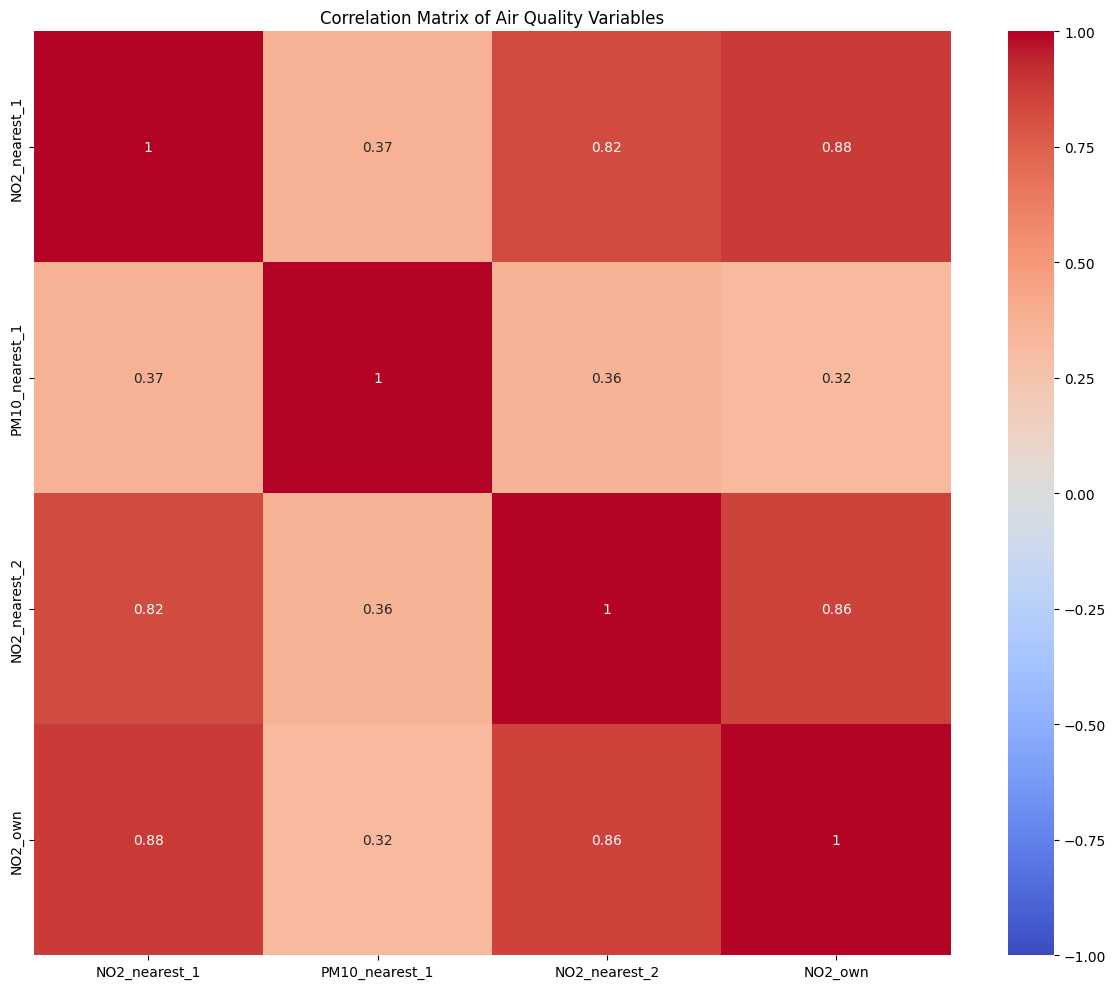

In [214]:
# Calcular la matriz de correlación
correlation_matrix = dataset.drop('Date', axis=1).corr()

# Crear el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0)
plt.title('Correlation Matrix of Air Quality Variables')
plt.tight_layout()
plt.show()

In [215]:
# 1. Preparar los datos
# Convertir fecha a características temporales
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['hour'] = dataset['Date'].dt.hour
dataset['day'] = dataset['Date'].dt.day
dataset['month'] = dataset['Date'].dt.month
dataset['day_of_week'] = dataset['Date'].dt.dayofweek

In [216]:
print("NaN values in dataset:")
print(dataset.isna().sum())

dataset_filled = dataset.copy()
dataset_filled = dataset_filled.fillna(dataset_filled.mean())


NaN values in dataset:
Date                 0
NO2_nearest_1      750
PM10_nearest_1    1032
NO2_nearest_2       57
NO2_own             82
hour                 0
day                  0
month                0
day_of_week          0
dtype: int64


Random Forest Results:
RMSE: 8.62
MAE: 6.34
R2 Score: 0.80

XGBoost Results:
RMSE: 9.48
MAE: 7.07
R2 Score: 0.76

Linear Regression Results:
RMSE: 8.12
MAE: 5.90
R2 Score: 0.82

Support Vector Regression Results:
RMSE: 11.55
MAE: 8.34
R2 Score: 0.65

Gradient Boosting Results:
RMSE: 8.16
MAE: 5.96
R2 Score: 0.82



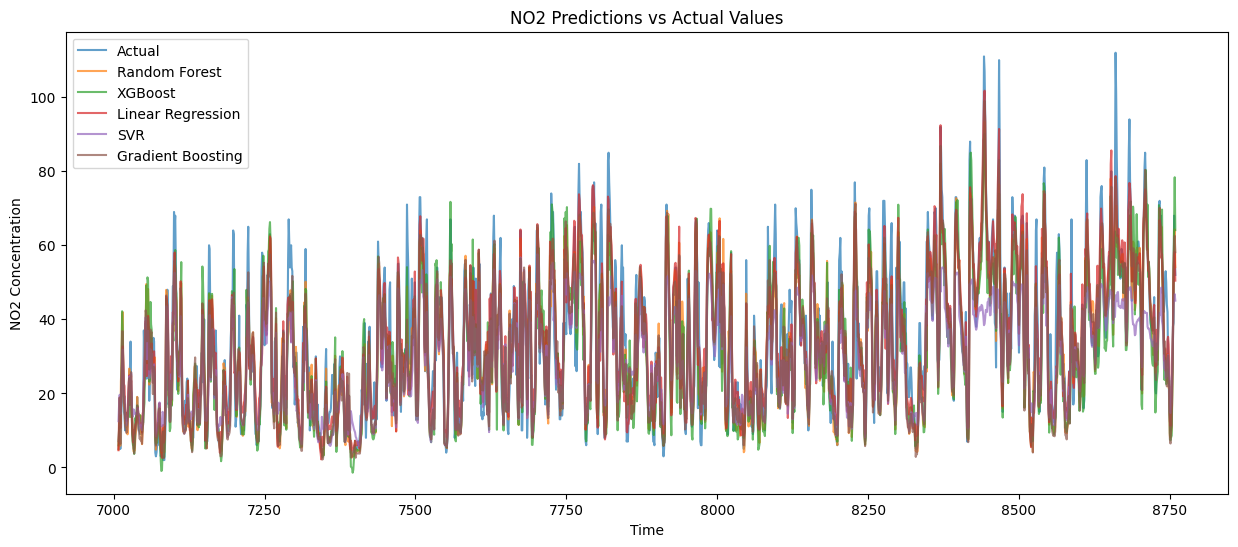

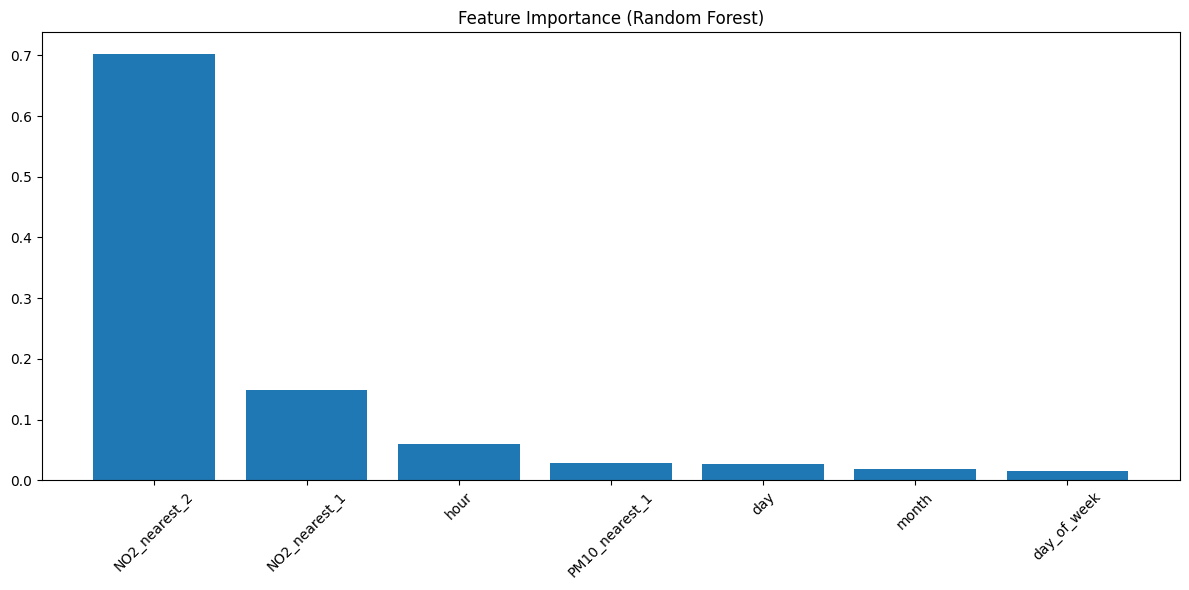

In [217]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Seleccionar features
# features = ['NO2_nearest_1',  'PM10_nearest_1',
#            'NO2_nearest_2',  'PM10_nearest_2',
#            'O3_own', 'PM25_own', 'PM10_own',
#            'hour', 'day', 'month', 'day_of_week']

# features = ['NO2_nearest_1',  'PM10_nearest_1',
#            'NO2_nearest_2',  
#            'O3_own',
#            'hour', 'day', 'month', 'day_of_week']


features = ['NO2_nearest_1',  'PM10_nearest_1',
           'NO2_nearest_2',  
           'hour', 'day', 'month', 'day_of_week']

X = dataset_filled[features]
y = dataset_filled['NO2_own']

# 2. Split de datos temporales
train_size = int(len(dataset) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# 3. Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Entrenar modelos
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Support Vector Regression
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# 5. Predicciones
rf_pred = rf_model.predict(X_test_scaled)
xgb_pred = xgb_model.predict(X_test_scaled)
lr_pred = lr_model.predict(X_test_scaled)
svr_pred = svr_model.predict(X_test_scaled)
gb_pred = gb_model.predict(X_test_scaled)

# 6. Evaluación
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}\n")

evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test, lr_pred, "Linear Regression")
evaluate_model(y_test, svr_pred, "Support Vector Regression")
evaluate_model(y_test, gb_pred, "Gradient Boosting")

# 7. Visualización de resultados
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual', alpha=0.7)
plt.plot(y_test.index, rf_pred, label='Random Forest', alpha=0.7)
plt.plot(y_test.index, xgb_pred, label='XGBoost', alpha=0.7)
plt.plot(y_test.index, lr_pred, label='Linear Regression', alpha=0.7)
plt.plot(y_test.index, svr_pred, label='SVR', alpha=0.7)
plt.plot(y_test.index, gb_pred, label='Gradient Boosting', alpha=0.7)
plt.title('NO2 Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('NO2 Concentration')
plt.legend()
plt.show()

# 8. Importancia de características para Random Forest
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [231]:
# modelos reales
# primer modelo:
own = "ES0694A"
nearest_1 = "ES2011A"
nearest_2 = "ES2012A"

# # segundo modelo:
own = "ES1120A"
nearest_1 = "ES1312A"
nearest_2 = "ES2109A"
# # no te no3 own

# # # tercer modelo:
# own = "ES1892A"
# nearest_1 = "ES1148A"
# nearest_2 = "ES1453A"

# # cuarto modelo:
# own = "ES1983A"
# nearest_1 = "ES1929A"
# nearest_2 = "ZAL"


In [232]:
dataset = pd.DataFrame({
    'Date': gene_sconcno2_2023_xvpca_emep_port['Date'],
    'NO2_nearest_1': gene_sconcno2_2023_xvpca_emep_port[nearest_1],
    'PM10_nearest_1': gene_pm10_hourly_df[nearest_1],
    'NO2_nearest_2': gene_sconcno2_2023_xvpca_emep_port[nearest_2],
    # 'O3_own': gene_sconco3_2023_xvpca_emep[own],
})

In [233]:
# 1. Preparar los datos
# Convertir fecha a características temporales
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['hour'] = dataset['Date'].dt.hour
dataset['day'] = dataset['Date'].dt.day
dataset['month'] = dataset['Date'].dt.month
dataset['day_of_week'] = dataset['Date'].dt.dayofweek

In [234]:
print("NaN values in dataset:")
print(dataset.isna().sum())

dataset_filled = dataset.copy()
dataset_filled = dataset_filled.fillna(dataset_filled.mean())


NaN values in dataset:
Date                 0
NO2_nearest_1      211
PM10_nearest_1    4248
NO2_nearest_2      458
hour                 0
day                  0
month                0
day_of_week          0
dtype: int64


In [235]:
# features = ['NO2_nearest_1',  'PM10_nearest_1',
#            'NO2_nearest_2',  
#            'O3_own',
#            'hour', 'day', 'month', 'day_of_week']

features = ['NO2_nearest_1',  'PM10_nearest_1',
           'NO2_nearest_2',  
           'hour', 'day', 'month', 'day_of_week']

X = dataset_filled[features]

X_scaled = scaler.transform(X)

# rf_pred = rf_model.predict(X_test_scaled)
# xgb_pred = xgb_model.predict(X_test_scaled)
# lr_pred = lr_model.predict(X_test_scaled)
# svr_pred = svr_model.predict(X_test_scaled)
gb_pred = gb_model.predict(X_scaled)

gb_pred

array([29.62959313, 32.2649623 , 32.06650265, ..., 13.52607297,
       14.141619  , 16.26037722])

In [236]:
predictions_df_2 = pd.DataFrame()

predictions_df_2["concentration"] = gb_pred
predictions_df_2["code"] = own
predictions_df_2["Date"] = dataset["Date"]
predictions_df_2

,concentration,code,Date
0,29.629593,ES1120A,2022-12-31 23:00:00
1,32.264962,ES1120A,2023-01-01 00:00:00
2,32.066503,ES1120A,2023-01-01 01:00:00
3,23.501219,ES1120A,2023-01-01 02:00:00
4,19.974470,ES1120A,2023-01-01 03:00:00
...,...,...,...
8755,14.809436,ES1120A,2023-12-31 18:00:00
8756,16.259432,ES1120A,2023-12-31 19:00:00
8757,13.526073,ES1120A,2023-12-31 20:00:00
8758,14.141619,ES1120A,2023-12-31 21:00:00


In [211]:
predictions_df_4 = pd.DataFrame()

predictions_df_4["concentration"] = gb_pred
predictions_df_4["code"] = own
predictions_df_4["Date"] = dataset["Date"]
predictions_df_4

,concentration,code,Date
0,47.369198,ES1983A,2022-12-31 23:00:00
1,32.556403,ES1983A,2023-01-01 00:00:00
2,30.092068,ES1983A,2023-01-01 01:00:00
3,24.213701,ES1983A,2023-01-01 02:00:00
4,21.283504,ES1983A,2023-01-01 03:00:00
...,...,...,...
8755,47.217795,ES1983A,2023-12-31 18:00:00
8756,56.509185,ES1983A,2023-12-31 19:00:00
8757,63.748557,ES1983A,2023-12-31 20:00:00
8758,64.393286,ES1983A,2023-12-31 21:00:00


In [205]:
predictions_df_3 = pd.DataFrame()

predictions_df_3["concentration"] = gb_pred
predictions_df_3["code"] = own
predictions_df_3["Date"] = dataset["Date"]
predictions_df_3


,concentration,code,Date
0,44.130667,ES1892A,2022-12-31 23:00:00
1,41.201743,ES1892A,2023-01-01 00:00:00
2,37.410704,ES1892A,2023-01-01 01:00:00
3,37.246223,ES1892A,2023-01-01 02:00:00
4,37.658097,ES1892A,2023-01-01 03:00:00
...,...,...,...
8755,40.154526,ES1892A,2023-12-31 18:00:00
8756,57.586286,ES1892A,2023-12-31 19:00:00
8757,73.729661,ES1892A,2023-12-31 20:00:00
8758,64.869926,ES1892A,2023-12-31 21:00:00


In [198]:
predictions_df = pd.DataFrame()

predictions_df['Date'] = dataset['Date']
predictions_df["code"] = own
predictions_df["concentration"] = gb_pred
predictions_df

,Date,code,concentration
0,2022-12-31 23:00:00,ES0694A,45.862706
1,2023-01-01 00:00:00,ES0694A,33.650627
2,2023-01-01 01:00:00,ES0694A,33.486473
3,2023-01-01 02:00:00,ES0694A,33.564911
4,2023-01-01 03:00:00,ES0694A,30.011374
...,...,...,...
8755,2023-12-31 18:00:00,ES0694A,41.929602
8756,2023-12-31 19:00:00,ES0694A,46.885310
8757,2023-12-31 20:00:00,ES0694A,41.551016
8758,2023-12-31 21:00:00,ES0694A,47.883251


In [240]:
# Concatenate all prediction dataframes
all_predictions = pd.concat([predictions_df, predictions_df_2, predictions_df_3, predictions_df_4], axis=0)
all_predictions = all_predictions.sort_values('Date')
all_predictions = all_predictions.reset_index(drop=True)
all_predictions


,Date,code,concentration
0,2022-12-31 23:00:00,ES0694A,45.862706
1,2022-12-31 23:00:00,ES1120A,29.629593
2,2022-12-31 23:00:00,ES1892A,44.130667
3,2022-12-31 23:00:00,ES1983A,47.369198
4,2023-01-01 00:00:00,ES1120A,32.264962
...,...,...,...
35035,2023-12-31 21:00:00,ES0694A,47.883251
35036,2023-12-31 22:00:00,ES1120A,16.260377
35037,2023-12-31 22:00:00,ES0694A,39.879449
35038,2023-12-31 22:00:00,ES1892A,62.470748


In [241]:
# Create mapping dictionary from code to coordinates based on the header comments
code_to_coords = {
    'ES0694A': (2.009802, 41.39216),
    'ES1120A': (1.191975, 41.11588), 
    'ES1892A': (2.237875, 41.44398),
    'ES1983A': (2.082141, 41.32177)
}

# Add lon and lat columns based on code mapping
all_predictions['lon'] = all_predictions['code'].map(lambda x: code_to_coords[x][0])
all_predictions['lat'] = all_predictions['code'].map(lambda x: code_to_coords[x][1])

# Drop the code column
all_predictions = all_predictions.drop('code', axis=1)

# Reorder columns
all_predictions = all_predictions[['Date', 'lon', 'lat', 'concentration']]
all_predictions


,Date,lon,lat,concentration
0,2022-12-31 23:00:00,2.009802,41.39216,45.862706
1,2022-12-31 23:00:00,1.191975,41.11588,29.629593
2,2022-12-31 23:00:00,2.237875,41.44398,44.130667
3,2022-12-31 23:00:00,2.082141,41.32177,47.369198
4,2023-01-01 00:00:00,1.191975,41.11588,32.264962
...,...,...,...,...
35035,2023-12-31 21:00:00,2.009802,41.39216,47.883251
35036,2023-12-31 22:00:00,1.191975,41.11588,16.260377
35037,2023-12-31 22:00:00,2.009802,41.39216,39.879449
35038,2023-12-31 22:00:00,2.237875,41.44398,62.470748


In [242]:
all_predictions.rename(columns={'Date': 'date'})[['date', 'lat', 'lon', 'concentration']]

,date,lat,lon,concentration
0,2022-12-31 23:00:00,41.39216,2.009802,45.862706
1,2022-12-31 23:00:00,41.11588,1.191975,29.629593
2,2022-12-31 23:00:00,41.44398,2.237875,44.130667
3,2022-12-31 23:00:00,41.32177,2.082141,47.369198
4,2023-01-01 00:00:00,41.11588,1.191975,32.264962
...,...,...,...,...
35035,2023-12-31 21:00:00,41.39216,2.009802,47.883251
35036,2023-12-31 22:00:00,41.11588,1.191975,16.260377
35037,2023-12-31 22:00:00,41.39216,2.009802,39.879449
35038,2023-12-31 22:00:00,41.44398,2.237875,62.470748


In [245]:
# all_predictions.index = all_predictions.index + 1
all_predictions['concentration'] = all_predictions['concentration'].round(1)
all_predictions.to_csv('./results/model_2/model_2_results_2.csv', index=True, index_label='id')


# model 3

In [60]:
# hacer mas de lo que ha funcionado

models = {
    'model_1': {
        'own': 'ES1148A',
        'nearest_1': 'ES1453A',
        'nearest_2': 'ES0691A'
    },
    'model_2': {
        'own': 'ES1992A',
        'nearest_1': 'ES0692A',
        'nearest_2': 'ES1396A'
    },
    'model_3': {
        'own': 'ES1438A',
        'nearest_1': 'ES1480A',
        'nearest_2': 'ES1396A'
    },
    'model_4': {
        'own': 'ES1679A',
        'nearest_1': 'ES0691A',
        'nearest_2': 'ES1438A'
    }
}


# modelos sin NO3 own ni nearest pm10  (tarragona)
# models = {
#     'model_1': {
#         'own': 'ES1124A',
#         'nearest_1': 'ES1122A',
#         'nearest_2': 'ES1123A'
#     },
#     'model_2': {
#         'own': 'ES1312A',
#         'nearest_1': 'ES1666A',
#         'nearest_2': 'ES2109A'
#     },
#     'model_3': {
#         'own': 'ES1666A',
#         'nearest_1': 'ES1312A',
#         'nearest_2': 'ES1123A'
#     }
# }


# Dictionary of models with their own and nearest stations
# models = {
#     'model_1': {
#         'own': 'ES0694A',
#         'nearest_1': 'ES2011A', 
#         'nearest_2': 'ES2012A'
#     },
#     'model_3': {
#         'own': 'ES1892A',
#         'nearest_1': 'ES1148A',
#         'nearest_2': 'ES1453A'
#     },
#     'model_4': {
#         'own': 'ES1983A',
#         'nearest_1': 'ES1929A',
#         'nearest_2': 'ZAL'
#     }
# }

models = {
    'model_2': {
        'own': 'ES1120A',
        'nearest_1': 'ES1312A',
        'nearest_2': 'ES2109A'
    }
}

In [62]:
all_models_dataset = pd.DataFrame()
for model in models:
    own = models[model]['own']
    nearest_1 = models[model]['nearest_1']
    nearest_2 = models[model]['nearest_2']

    dataset = pd.DataFrame({
        'Date': gene_sconcno2_2023_xvpca_emep_port['Date'],
        'NO2_nearest_1': gene_sconcno2_2023_xvpca_emep_port[nearest_1],
        # 'PM10_nearest_1': gene_pm10_hourly_df[nearest_1],
        'NO2_nearest_2': gene_sconcno2_2023_xvpca_emep_port[nearest_2],
        # 'O3_own': gene_sconco3_2023_xvpca_emep[own],
        # 'NO2_own': gene_sconcno2_2023_xvpca_emep_port[own],
        'code': own
    })

    all_models_dataset = pd.concat([all_models_dataset, dataset], axis=0)

all_models_dataset


,Date,NO2_nearest_1,NO2_nearest_2,code
0,2022-12-31 23:00:00,24.0,23.0,ES1120A
1,2023-01-01 00:00:00,27.0,22.0,ES1120A
2,2023-01-01 01:00:00,26.0,24.0,ES1120A
3,2023-01-01 02:00:00,18.0,21.0,ES1120A
4,2023-01-01 03:00:00,11.0,19.0,ES1120A
...,...,...,...,...
8755,2023-12-31 18:00:00,19.0,NaN,ES1120A
8756,2023-12-31 19:00:00,19.0,NaN,ES1120A
8757,2023-12-31 20:00:00,13.0,NaN,ES1120A
8758,2023-12-31 21:00:00,9.0,NaN,ES1120A


In [63]:
dataset = all_models_dataset

# 1. Preparar los datos
# Convertir fecha a características temporales
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['hour'] = dataset['Date'].dt.hour
dataset['day'] = dataset['Date'].dt.day
dataset['month'] = dataset['Date'].dt.month
dataset['day_of_week'] = dataset['Date'].dt.dayofweek


print("NaN values in dataset:")
print(dataset.isna().sum())

dataset_filled = dataset.copy()
dataset_filled = dataset_filled.drop('code', axis=1)
dataset_filled = dataset_filled.fillna(dataset_filled.mean())

NaN values in dataset:
Date               0
NO2_nearest_1    211
NO2_nearest_2    458
code               0
hour               0
day                0
month              0
day_of_week        0
dtype: int64


In [64]:
# extract dataset
dataset_filled["code"] = dataset["code"]
# Create mapping dictionary from code to coordinates based on the header comments
code_to_coords = {
    'ES0694A': (2.009802, 41.39216),
    'ES1120A': (1.191975, 41.11588), 
    'ES1892A': (2.237875, 41.44398),
    'ES1983A': (2.082141, 41.32177),
    'ES1148A': (2.222245, 41.425621),
    'ES1992A': (2.115661, 41.387273),
    'ES1438A': (2.15403, 41.385366),
    'ES1679A': (2.187417, 41.386414),
    'ES1124A': (1.239709, 41.159532),
    'ES1312A': (1.200765, 41.103678),
    'ES1666A': (1.24165, 41.117388)
}

# Add lon and lat columns based on code mapping
dataset_filled['lon'] = dataset_filled['code'].map(lambda x: code_to_coords[x][0])
dataset_filled['lat'] = dataset_filled['code'].map(lambda x: code_to_coords[x][1])

dataset_filled

,Date,NO2_nearest_1,NO2_nearest_2,hour,day,month,day_of_week,code,lon,lat
0,2022-12-31 23:00:00,24.0,23.000000,23,31,12,5,ES1120A,1.191975,41.11588
1,2023-01-01 00:00:00,27.0,22.000000,0,1,1,6,ES1120A,1.191975,41.11588
2,2023-01-01 01:00:00,26.0,24.000000,1,1,1,6,ES1120A,1.191975,41.11588
3,2023-01-01 02:00:00,18.0,21.000000,2,1,1,6,ES1120A,1.191975,41.11588
4,2023-01-01 03:00:00,11.0,19.000000,3,1,1,6,ES1120A,1.191975,41.11588
...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 18:00:00,19.0,14.216695,18,31,12,6,ES1120A,1.191975,41.11588
8756,2023-12-31 19:00:00,19.0,14.216695,19,31,12,6,ES1120A,1.191975,41.11588
8757,2023-12-31 20:00:00,13.0,14.216695,20,31,12,6,ES1120A,1.191975,41.11588
8758,2023-12-31 21:00:00,9.0,14.216695,21,31,12,6,ES1120A,1.191975,41.11588


In [65]:
dataset_filled.to_csv('./data_ams/dataset_tarragona_real.csv')

NaN values in dataset:
Date               0
NO2_nearest_1    686
NO2_nearest_2    794
NO2_own          401
hour               0
day                0
month              0
day_of_week        0
dtype: int64
Random Forest Results:
RMSE: 11.20
MAE: 7.17
R2 Score: 0.47

XGBoost Results:
RMSE: 11.14
MAE: 7.05
R2 Score: 0.48

Linear Regression Results:
RMSE: 11.44
MAE: 7.41
R2 Score: 0.45

Support Vector Regression Results:
RMSE: 11.73
MAE: 7.37
R2 Score: 0.42

Gradient Boosting Results:
RMSE: 11.09
MAE: 7.08
R2 Score: 0.48



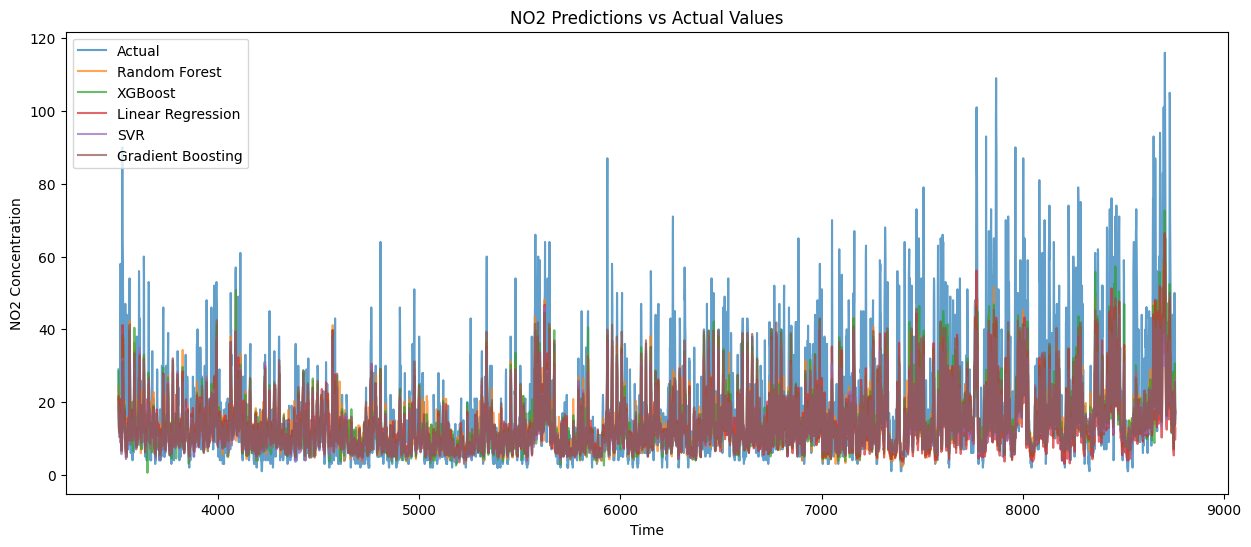

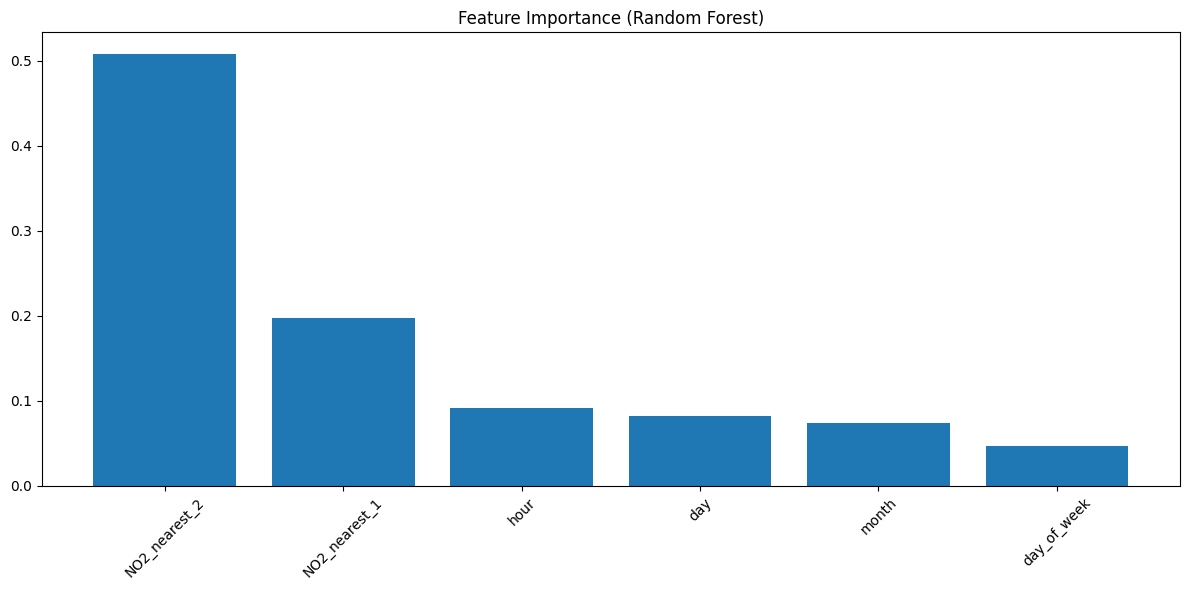

In [326]:



# features = ['NO2_nearest_1',  'PM10_nearest_1',
#            'NO2_nearest_2',  "O3_own",
#            'hour', 'day', 'month', 'day_of_week']

features = ['NO2_nearest_1', 
           'NO2_nearest_2',  
           'hour', 'day', 'month', 'day_of_week']

X = dataset_filled[features]
y = dataset_filled['NO2_own']

# 2. Split de datos temporales
train_size = int(len(dataset) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# 3. Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Entrenar modelos
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Support Vector Regression
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# 5. Predicciones
rf_pred = rf_model.predict(X_test_scaled)
xgb_pred = xgb_model.predict(X_test_scaled)
lr_pred = lr_model.predict(X_test_scaled)
svr_pred = svr_model.predict(X_test_scaled)
gb_pred = gb_model.predict(X_test_scaled)

# 6. Evaluación
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}\n")

evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test, lr_pred, "Linear Regression")
evaluate_model(y_test, svr_pred, "Support Vector Regression")
evaluate_model(y_test, gb_pred, "Gradient Boosting")

# 7. Visualización de resultados
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual', alpha=0.7)
plt.plot(y_test.index, rf_pred, label='Random Forest', alpha=0.7)
plt.plot(y_test.index, xgb_pred, label='XGBoost', alpha=0.7)
plt.plot(y_test.index, lr_pred, label='Linear Regression', alpha=0.7)
plt.plot(y_test.index, svr_pred, label='SVR', alpha=0.7)
plt.plot(y_test.index, gb_pred, label='Gradient Boosting', alpha=0.7)
plt.title('NO2 Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('NO2 Concentration')
plt.legend()
plt.show()

# 8. Importancia de características para Random Forest
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


In [327]:
# Dictionary of models with their own and nearest stations
models = {
    'model_1': {
        'own': 'ES0694A',
        'nearest_1': 'ES2011A', 
        'nearest_2': 'ES2012A'
    },
    'model_3': {
        'own': 'ES1892A',
        'nearest_1': 'ES1148A',
        'nearest_2': 'ES1453A'
    },
    'model_4': {
        'own': 'ES1983A',
        'nearest_1': 'ES1929A',
        'nearest_2': 'ZAL'
    }
}

models = {
    'model_2': {
        'own': 'ES1120A',
        'nearest_1': 'ES1312A',
        'nearest_2': 'ES2109A'
    }
}

In [328]:
all_models_dataset = pd.DataFrame()
for model in models:
    own = models[model]['own']
    nearest_1 = models[model]['nearest_1']
    nearest_2 = models[model]['nearest_2']

    dataset = pd.DataFrame({
        'Date': gene_sconcno2_2023_xvpca_emep_port['Date'],
        'NO2_nearest_1': gene_sconcno2_2023_xvpca_emep_port[nearest_1],
        # 'PM10_nearest_1': gene_pm10_hourly_df[nearest_1],
        'NO2_nearest_2': gene_sconcno2_2023_xvpca_emep_port[nearest_2],
        # 'O3_own': gene_sconco3_2023_xvpca_emep[own],
        "code": own
    })

    all_models_dataset = pd.concat([all_models_dataset, dataset], axis=0)

all_models_dataset


,Date,NO2_nearest_1,NO2_nearest_2,code
0,2022-12-31 23:00:00,24.0,23.0,ES1120A
1,2023-01-01 00:00:00,27.0,22.0,ES1120A
2,2023-01-01 01:00:00,26.0,24.0,ES1120A
3,2023-01-01 02:00:00,18.0,21.0,ES1120A
4,2023-01-01 03:00:00,11.0,19.0,ES1120A
...,...,...,...,...
8755,2023-12-31 18:00:00,19.0,NaN,ES1120A
8756,2023-12-31 19:00:00,19.0,NaN,ES1120A
8757,2023-12-31 20:00:00,13.0,NaN,ES1120A
8758,2023-12-31 21:00:00,9.0,NaN,ES1120A


In [329]:

dataset = all_models_dataset

dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['hour'] = dataset['Date'].dt.hour
dataset['day'] = dataset['Date'].dt.day
dataset['month'] = dataset['Date'].dt.month
dataset['day_of_week'] = dataset['Date'].dt.dayofweek

print("NaN values in dataset:")
print(dataset.isna().sum())

dataset_filled = dataset.copy()
dataset_filled = dataset_filled.drop('code', axis=1)
dataset_filled = dataset_filled.fillna(dataset_filled.mean())

features = ['NO2_nearest_1',  'PM10_nearest_1',
           'NO2_nearest_2',  'O3_own',
           'hour', 'day', 'month', 'day_of_week']

features = ['NO2_nearest_1', 
           'NO2_nearest_2',  
           'hour', 'day', 'month', 'day_of_week']

X = dataset_filled[features]

X_scaled = scaler.transform(X)

gb_pred = gb_model.predict(X_scaled)

gb_pred

NaN values in dataset:
Date               0
NO2_nearest_1    211
NO2_nearest_2    458
code               0
hour               0
day                0
month              0
day_of_week        0
dtype: int64


array([24.1078491 , 21.58220845, 21.22056087, ..., 16.63249004,
       15.6431044 , 16.58784452])

In [330]:
predictions_df_2 = pd.DataFrame({
    "concentration": gb_pred,
    "code": all_models_dataset["code"].values,
    "Date": all_models_dataset["Date"].values
})


In [320]:
predictions_df = pd.DataFrame({
    "concentration": gb_pred,
    "code": all_models_dataset["code"].values,
    "Date": all_models_dataset["Date"].values
})


In [332]:
predictions_df = pd.concat([predictions_df, predictions_df_2], axis=0)


In [334]:
predictions_df = predictions_df.reset_index(drop=True)
predictions_df = predictions_df.sort_values('Date')


In [335]:
# Create mapping dictionary from code to coordinates based on the header comments
code_to_coords = {
    'ES0694A': (2.009802, 41.39216),
    'ES1120A': (1.191975, 41.11588), 
    'ES1892A': (2.237875, 41.44398),
    'ES1983A': (2.082141, 41.32177)
}

# Add lon and lat columns based on code mapping
predictions_df['lon'] = predictions_df['code'].map(lambda x: code_to_coords[x][0])
predictions_df['lat'] = predictions_df['code'].map(lambda x: code_to_coords[x][1])

# Drop the code column
predictions_df = predictions_df.drop('code', axis=1)

# Reorder columns
predictions_df = predictions_df[['Date', 'lon', 'lat', 'concentration']]
predictions_df


,Date,lon,lat,concentration
0,2022-12-31 23:00:00,2.009802,41.39216,46.419514
8760,2022-12-31 23:00:00,2.237875,41.44398,33.631803
17520,2022-12-31 23:00:00,2.082141,41.32177,43.796520
26280,2022-12-31 23:00:00,1.191975,41.11588,24.107849
8761,2023-01-01 00:00:00,2.237875,41.44398,37.751164
...,...,...,...,...
8758,2023-12-31 21:00:00,2.009802,41.39216,48.573361
17519,2023-12-31 22:00:00,2.237875,41.44398,48.084772
8759,2023-12-31 22:00:00,2.009802,41.39216,42.656691
26279,2023-12-31 22:00:00,2.082141,41.32177,55.366330


In [336]:
predictions_df = predictions_df.reset_index(drop=True)
predictions_df.rename(columns={'Date': 'date'})[['date', 'lat', 'lon', 'concentration']]


,date,lat,lon,concentration
0,2022-12-31 23:00:00,41.39216,2.009802,46.419514
1,2022-12-31 23:00:00,41.44398,2.237875,33.631803
2,2022-12-31 23:00:00,41.32177,2.082141,43.796520
3,2022-12-31 23:00:00,41.11588,1.191975,24.107849
4,2023-01-01 00:00:00,41.44398,2.237875,37.751164
...,...,...,...,...
35035,2023-12-31 21:00:00,41.39216,2.009802,48.573361
35036,2023-12-31 22:00:00,41.44398,2.237875,48.084772
35037,2023-12-31 22:00:00,41.39216,2.009802,42.656691
35038,2023-12-31 22:00:00,41.32177,2.082141,55.366330


In [339]:
predictions_df.index = predictions_df.index -1
# predictions_df['concentration'] = predictions_df['concentration'].round(1)
predictions_df.to_csv('./results/model_2/model_3_results_1.csv', index=True, index_label='id')
